In [1]:
import os
import random
from dotenv import load_dotenv
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage
from typing import Annotated, List, Literal, Optional
from langgraph.graph.message import add_messages
from IPython.display import Image, display
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
# llm=ChatGroq(model="qwen-2.5-32b")
llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-db1f74ce-9b4c-4f43-809c-534d4b8b5480-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [3]:
class State(TypedDict):
    """
    Represents the software life cycle model state.
    """
    messages: Annotated[list[SystemMessage | HumanMessage | AIMessage], "add_messages"]
    userInput: str
    userStories: Optional[str]
    productOwnerReviewStatus: Optional[Literal["approved", "feedback"]]
    designDocuments: Optional[str]
    designReviewStatus: Optional[Literal["approved", "feedback"]]
    generatedCode: Optional[str]
    codeReviewStatus: Optional[Literal["approved", "feedback"]]
    securityReviewStatus: Optional[Literal["approved", "feedback"]]
    testCases: Optional[str]
    testCaseReviewStatus: Optional[Literal["approved", "feedback"]]
    qaTestingStatus: Optional[Literal["passed", "failed"]]
    deploymentStatus: Optional[Literal["deployed", "failed"]]
    status: Optional[str]
    feedback1: Optional[str]
    feedback2: Optional[str]
    feedback3: Optional[str]
    feedback4: Optional[str]
    
class Feedback(BaseModel):
    '''
    This class represents the feedbacks present in the workflow.
    '''
    productOwnerReviewStatus: Literal["approved", "feedback"] = Field(
        description="Review if the user-generated stories are approved or not.",
    )
    feedback1: str = Field(
        description="If the user stories are not approved, provide feedback to auto-generate user stories again and improve them.",
    )
    designReviewStatus: Literal["approved", "feedback"] = Field(
        description="Review if the design documents are well-structured.",
    )
    feedback2: str = Field(
        description="If design documents are not approved, provide feedback to refine them.",
    )
    codeReviewStatus: Literal["approved", "feedback"] = Field(
        description="Review if the generated code meets the requirements.",
    )
    feedback3: str = Field(
        description="If the code is not approved, provide feedback for fixes.",
    )
    testCaseReviewStatus: Literal["approved", "feedback"] = Field(
        description="Review if the test cases are properly defined.",
    )
    feedback4: str = Field(
        description="If test cases are not approved, provide feedback for refinement.",
    )
    
evaluator = llm.with_structured_output(Feedback)

def userInputRequirement(state: State):
    '''
    This is the first node after START state.
    The user provides requirements and requirements gathering starts.
    '''
    userInput = input("Automating a software life cycle model and getting UI: User Input requirements for generating user stories")
    return {"userInput": userInput}


def generateUserStories(state: State):
    """
    This node generates user stories based on userInput using an LLM.
    The output is then stored in state['userStories'] and passed for Product Owner Review.
    """    
    msg = llm.invoke(f"You are automating a software life cycle model and creating user stories for User Input: {state['userInput']}")
    return {"userStories": msg.content.strip()}

def productOwnerReview(state: State):
    """
    Simulates a product owner reviewing the generated user stories.
    - If approved, proceeds to the next stage.
    - If feedback is needed, it routes to reviseUserStories.
    """
    userStories = state.get("userStories", "No user stories provided.")

    reviewFeedback = llm.invoke(f"""
    You are a product owner reviewing the following user stories:
    
    {userStories}
    
    Determine if the user stories are well-defined and actionable.
    Respond with either 'approved' if they are good to proceed, 
    or 'feedback' if improvements are needed.
    """)

    state["productOwnerReviewStatus"] = reviewFeedback.content.lower()

    if "approved" in state["productOwnerReviewStatus"]:
        return {"next_step": "approved"} 
    else:
        return {
            "next_step": "feedback",
            "feedback_details": state.get("feedback1", "No feedback available."),
        } 


def route_product_owner_review(state: State):
    """
    Routes the workflow to Create Design Documents if approved or to Revise User Stories if feedback.
    """
    if state.get("productOwnerReviewStatus") == "approved":
        return "approved"
    elif state.get("productOwnerReviewStatus") == "feedback":
        return "feedback"


def reviseUserStories(state: State):
    """
    This node refines the user stories based on the product owner's feedback.
    It then sends them back for review
    """
    userStories = state.get("userStories", "No user stories provided.")
    
    revisedStories = llm.invoke(f"""
    The product owner has given feedback that the user stories need improvement.
    Here are the original user stories:
    
    {userStories}
    
    Please refine them to make them more actionable, detailed, and aligned with best practices.
    Provide a clear and structured update.
    """)
    state["userStories"] = revisedStories.content.strip()
    return {"userStories": state["userStories"]}


def createDesignDocuments(state: State):
    """
    This node creates functional and technical design documents 
    based on the approved user stories.
    """
    userStories = state.get("userStories", "No user stories provided.")
    
    designDocs = llm.invoke(f"""
    Based on the following user stories, generate functional and technical 
    design documents to guide development:
    
    {userStories}

    The design should include:
    - Functional requirements
    - System architecture
    - APIs and data flow
    - Any other key technical details
    Provide a structured and clear document.
    """)
    state["designDocuments"] = designDocs.content.strip()
    return {"designDocuments": state["designDocuments"]}


def designReview(state: State):
    """
    This node reviews the functional and technical design documents.
    If approved, it moves to the next phase (code generation).
    If feedback is needed, the process returns to createDesignDocuments.
    """
    designDocuments = state.get("designDocuments", "No design documents provided.")

    reviewFeedback = llm.invoke(f"""
    You are reviewing the following functional and technical design documents:
    
    {designDocuments}
    
    Determine if they are complete, well-structured, and ready for development.
    Respond with either:
    - 'approved' if the design is good to proceed, or
    - 'feedback' if improvements are needed.
    """)
    state["designReviewStatus"] = reviewFeedback.content.lower()
    
    if "approved" in state["designReviewStatus"]:
        return {"next_step": "approved"}
    else:
        return {
            "next_step": "feedback",
            "feedback_details": "Update the design documents based on feedback."
        }


def route_design_review(state: State):
    """
    Routes the workflow based on the Design Review.
    If 'approved', move to 'generateCode'.
    If 'feedback', go back to 'createDesignDocuments'.
    """
    if state.get("designReviewStatus") == "approved":
        return "approved"
    elif state.get("designReviewStatus") == "feedback":
        return "feedback"


def generateCode(state: State):
    """
    This function generates code based on the approved design documents.
    """
    designDocuments = state.get("designDocuments", "No design documents provided.")

    code = llm.invoke(f"""
    Based on the following functional and technical design documents, generate code.
    
    {designDocuments}

    The code should follow best practices, be modular, and be well-commented.
    """)
    
    state["generatedCode"] = code.content.strip()
    return {"generatedCode": state["generatedCode"]}

def codeReview(state: State):
    """
    This node reviews the generated code for quality, best practices, 
    and adherence to the design specifications.
    - If approved, moves to security review.
    - If feedback is needed, the developer must fix issues.
    """
    code = state.get("generatedCode", "No code generated.")

    reviewFeedback = llm.invoke(f"""
    You are reviewing the generated code.
    
    - Ensure the code follows best practices.
    - Check for any logical errors or improvements.
    - Confirm adherence to the provided design.
    
    {code}
    
    Respond with either 'approved' if the code is good to proceed, 
    or 'feedback' if it needs improvements.
    """)

    state["codeReviewStatus"] = reviewFeedback.content.lower()

    if "approved" in state["codeReviewStatus"]:
        return {"next_step": "approved"}
    else:
        return {
            "next_step": "feedback",
            "feedback_details": state.get("feedback3", "No feedback available."),
        } 


def fixCodeAfterCodeReview(state: State):
    """
    If the code review results in feedback, the code needs to be fixed.
    """
    code = state.get("generatedCode", "No code provided.")

    improvedCode = llm.invoke(f"""
    The code review provided the following feedback requiring improvements.
    
    {state.get('feedback3', 'No feedback given.')}
    
    Fix the issues and enhance the code based on the feedback.
    
    {code}
    
    Ensure it meets the best standards before the next review.
    """)

    state["generatedCode"] = improvedCode.content.strip()
    return {"generatedCode": state["generatedCode"]}


def route_code_review(state: State):
    """
    Routes the workflow based on the Code Review.
    If 'approved', move to 'securityReview'.
    If 'feedback', go back to 'fixCodeAfterCodeReview'.
    """
    if state.get("codeReviewStatus") == "approved":
        return "approved"
    elif state.get("codeReviewStatus") == "feedback":
        return "feedback"


def securityReview(state: State):
    """
    This node performs a security review of the code.
    """
    code = state.get("generatedCode", "No code provided.")
    
    securityFeedback = llm.invoke(f"""
    Conduct a security review of the generated code.
    
    {code}
    
    - Identify security vulnerabilities.
    - Check for secure coding practices.
    - Ensure protection against common exploits.

    Respond with either 'approved' if the code is secure or 'feedback' if it needs improvements.
    """)

    state["securityReviewStatus"] = securityFeedback.content.lower()

    if "approved" in state["securityReviewStatus"]:
        return {"next_step": "approved"}
    else:
        return {
            "next_step": "feedback",
            "feedback_details": "Address security vulnerabilities in the code.",
        }


def fixCodeAfterSecurity(state: State):
    """
    If the security review results in feedback, the code needs to be fixed.
    """
    code = state.get("generatedCode", "No code provided.")

    fixedCode = llm.invoke(f"""
    The security review provided the following feedback requiring improvements.
    
    {state.get('feedback4', 'No feedback given.')}
    
    Fix the issues and enhance the security based on the feedback.
    
    {code}
    
    Fix the security vulnerabilities and ensure the code is secure before proceeding.
    """)

    state["generatedCode"] = fixedCode.content.strip()
    return {"generatedCode": state["generatedCode"]}


def route_security_review(state: State):
    """
    Routes the workflow based on the Security Review.
    If 'approved', move to 'writeTestCases'.
    If 'feedback', go back to 'fixCodeAfterSecurity'.
    """
    if state.get("securityReviewStatus") == "approved":
        return "approved"
    elif state.get("securityReviewStatus") == "feedback":
        return "feedback"



def writeTestCases(state: State):
    """
    This node writes test cases based on the generated code.
    """
    code = state.get("generatedCode", "No code provided.")

    testCases = llm.invoke(f"""
    Write detailed test cases for the following generated code.
    
    {code}
    
    - Cover all functionalities.
    - Include unit, integration, and edge cases.
    - Ensure proper validation.
    """)

    state["testCases"] = testCases.content.strip()
    return {"testCases": state["testCases"]}


def testCasesReview(state: State):
    """
    This node reviews the written test cases for accuracy and completeness.
    """
    testCases = state.get("testCases", "No test cases provided.")

    reviewFeedback = llm.invoke(f"""
    Review the following test cases to ensure they are complete and cover all scenarios.
    
    {testCases}

    Respond with either 'approved' if the test cases are good to proceed,
    or 'feedback' if they need improvements.
    """)

    state["testCaseReviewStatus"] = reviewFeedback.content.lower()

    if "approved" in state["testCaseReviewStatus"]:
        return {"next_step": "approved"}
    else:
        return {
            "next_step": "feedback",
            "feedback_details": state.get("feedback4", "No feedback available."),
        }


def fixTestCasesAfterReview(state: State):
    """
    If the test case review results in feedback, this function refines the test cases.
    """
    testCases = state.get("testCases", "No test cases provided.")

    refinedTestCases = llm.invoke(f"""
    The following test cases review provided feedback requiring improvements.
    
    {testCases}
    
    Please revise and refine the test cases to ensure they are complete,
    well-structured, and cover all possible scenarios, including edge cases.
    """)

    state["testCases"] = refinedTestCases.content.strip()
    return {"testCases": state["testCases"]}


def route_test_cases_review(state: State):
    """
    Routes the workflow based on the Test Cases Review.
    If 'approved', move to 'qaTesting'.
    If 'feedback', go back to 'fixTestCasesAfterReview'.
    """
    if state.get("testCaseReviewStatus") == "approved":
        return "approved"
    elif state.get("testCaseReviewStatus") == "feedback":
        return "feedback"


def qaTesting(state: State):
    """
    This node executes QA testing based on approved test cases.
    """
    qaResult = random.choice(["passed", "failed"])  # Simulating pass/fail scenario

    state["qaTestingStatus"] = qaResult

    if qaResult == "passed":
        return {"next_step": "deployment"}
    else:
        return {
            "next_step": "fix_code_after_qa",
            "feedback_details": "Fix issues found during QA testing.",
        }


def fixCodeAfterQAFeedback(state: State):
    """
    If the QA testing results in failure, this function fixes the code accordingly.
    """
    code = state.get("generatedCode", "No code provided.")
    
    codeAfterQA = llm.invoke(f"""
    The QA testing phase has failed, and the application contains issues that need fixing.
    Following is the improved code
    
    {code}
    
    - Identify the reported bugs.
    - Debug the application to resolve issues.
    - Ensure the application passes QA in the next cycle.
    
    Provide the updated code.
    """)

    state["generatedCode"] = codeAfterQA.content.strip()
    return {"generatedCode": state["generatedCode"]}


def route_qa_testing(state: State):
    """
    Routes the workflow based on QA Testing results.
    If 'passed', move to 'deployment'.
    If 'failed', go back to 'fixCodeAfterQAFeedback'.
    """
    if state.get("qaTestingStatus") == "passed":
        return "deployment"
    elif state.get("qaTestingStatus") == "failed":
        return "fix_code_after_qa"


def deployment(state: State):
    """
    Deploys the application if QA testing has passed.
    """
    state["deploymentStatus"] = "deployed"

    return {"deploymentStatus": "deployed"}


def monitoringAndFeedback(state: State):
    """
    This node monitors the deployed system and collects feedback.
    """
    return {"status": "Monitoring and giving Feedbacks."}


def maintenanceAndUpdates(state: State):
    """
    This node performs maintenance and updates based on feedback.
    """
    return {"status": "Maintenance and performing updates."}


def route_maintenance_and_updates(state: State):
    """
    Routes the workflow based on Maintenance and Updates.
    If maintenance is complete, the process ends and returns END
    Otherwise, it continues monitoring and feedback and returns to user input .
    """
    
    if state.get("status") == "END":
        return {"status": "Completed SDLC model with complex multi level reviews"}
    elif state.get("Status") == "failed":
        return {
            "status": "SDLC model failed",
            "next_step": "userInput"
            }

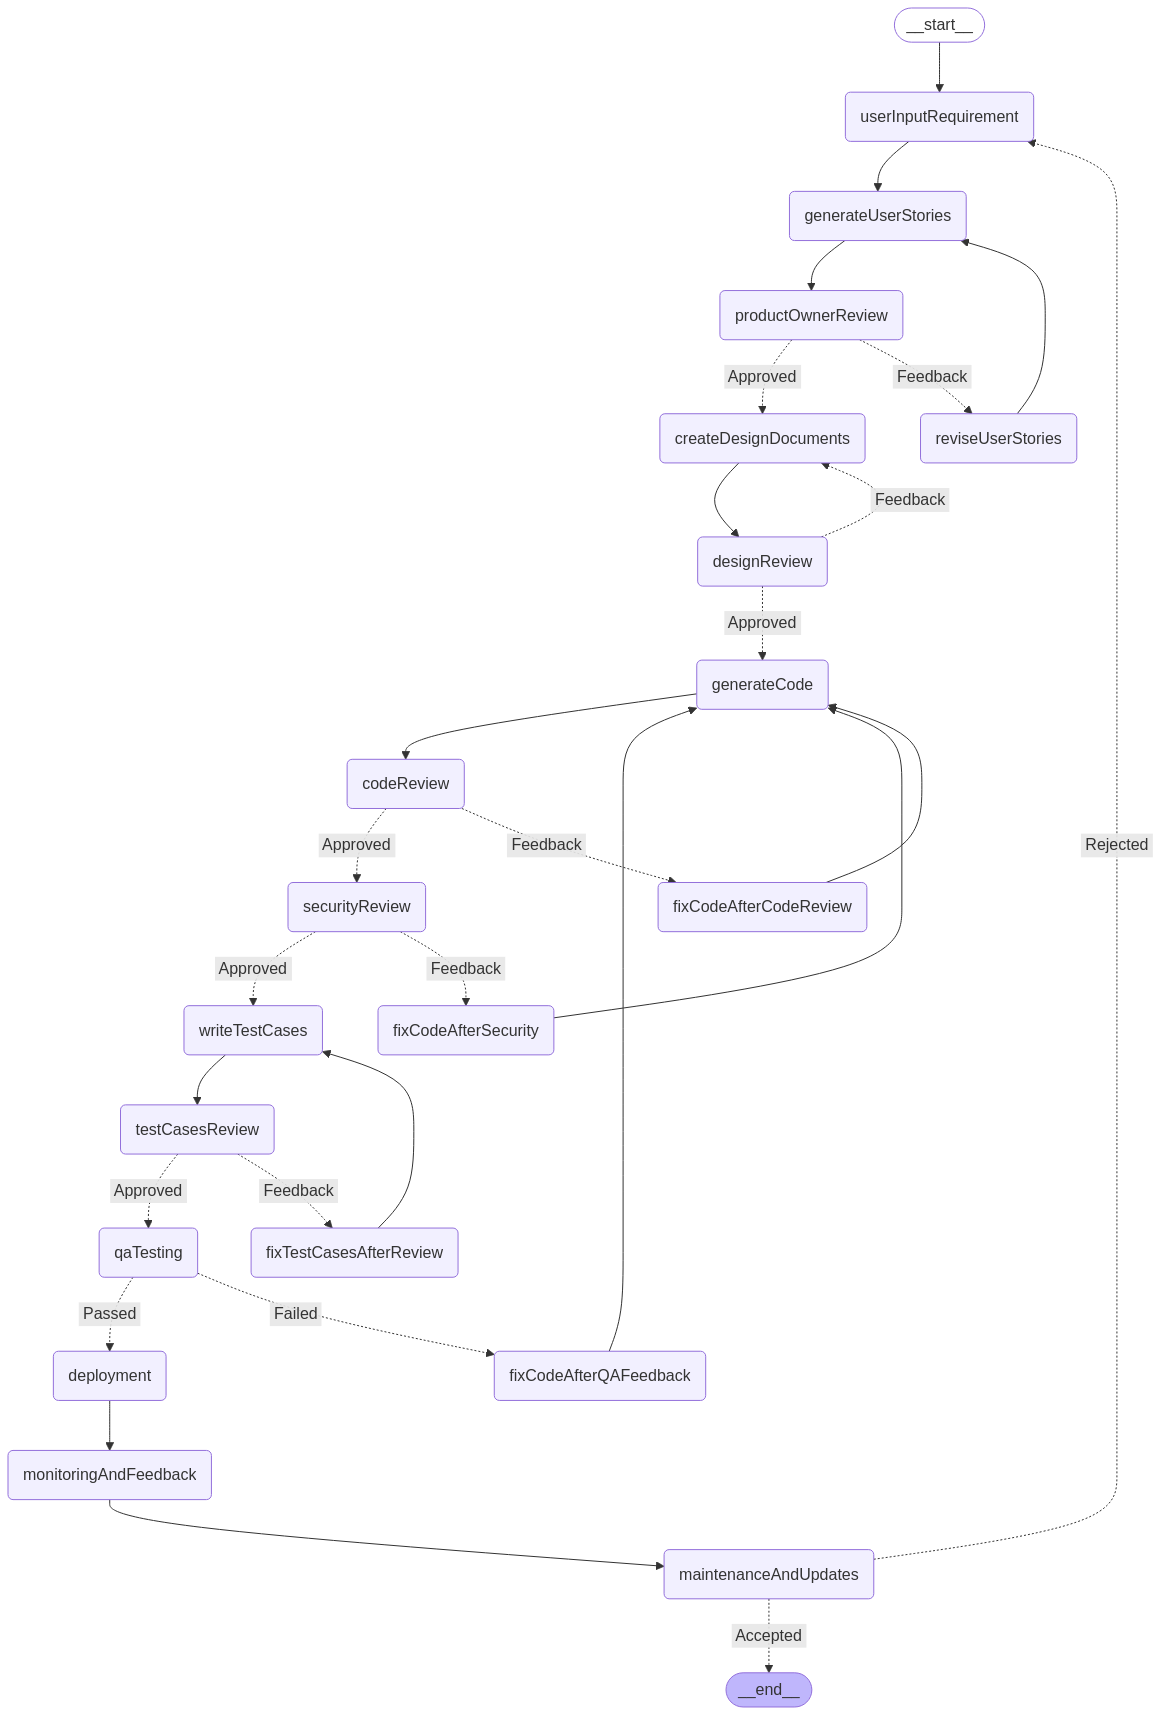

In [4]:
# Build workflow
workflow = StateGraph(State)

# workflow1 = StateGraph(AgentState)
# workflow2 = StateGraph(subGraph_1)
# workflow3 = StateGraph(subGraph_2)

# Add nodes
workflow.add_node("userInputRequirement", userInputRequirement)
workflow.add_node("generateUserStories", generateUserStories)
workflow.add_node("productOwnerReview", productOwnerReview)
workflow.add_node("reviseUserStories", reviseUserStories)
workflow.add_node("createDesignDocuments", createDesignDocuments)
workflow.add_node("designReview", designReview)
workflow.add_node("generateCode", generateCode)
workflow.add_node("codeReview", codeReview)
workflow.add_node("fixCodeAfterCodeReview", fixCodeAfterCodeReview)
workflow.add_node("securityReview", securityReview)
workflow.add_node("fixCodeAfterSecurity", fixCodeAfterSecurity)
workflow.add_node("writeTestCases", writeTestCases)
workflow.add_node("testCasesReview", testCasesReview)
workflow.add_node("fixTestCasesAfterReview", fixTestCasesAfterReview)
workflow.add_node("qaTesting", qaTesting)
workflow.add_node("fixCodeAfterQAFeedback", fixCodeAfterQAFeedback)
workflow.add_node("deployment", deployment)
workflow.add_node("monitoringAndFeedback", monitoringAndFeedback)
workflow.add_node("maintenanceAndUpdates", maintenanceAndUpdates)


# # Workflow 1
# workflow1.add_node("userInputRequirement", userInputRequirement)
# workflow1.add_node("subGraph1", subGraph1)
# workflow1.add_node("subGraph2", subGraph2)
# workflow1.add_node("deployment", deployment)
# workflow1.add_node("monitoringAndFeedback", monitoringAndFeedback)
# workflow1.add_node("maintenanceAndUpdates", maintenanceAndUpdates)

# # Workflow 2
# workflow2.add_node("generateUserStories", generateUserStories)
# workflow2.add_node("productOwnerReview", productOwnerReview)
# workflow2.add_node("reviseUserStories", reviseUserStories)
# workflow2.add_node("createDesignDocuments", createDesignDocuments)
# workflow2.add_node("designReview", designReview)

# # Workflow 3
# workflow3.add_node("generateCode", generateCode)
# workflow3.add_node("codeReview", codeReview)
# workflow3.add_node("fixCodeAfterCodeReview", fixCodeAfterCodeReview)
# workflow3.add_node("securityReview", securityReview)
# workflow3.add_node("fixCodeAfterSecurity", fixCodeAfterSecurity)
# workflow3.add_node("writeTestCases", writeTestCases)
# workflow3.add_node("testCasesReview", testCasesReview)
# workflow3.add_node("fixTestCasesAfterReview", fixTestCasesAfterReview)
# workflow3.add_node("qaTesting", qaTesting)
# workflow3.add_node("fixCodeAfterQAFeedback", fixCodeAfterQAFeedback)

# Add edges to connect nodes
workflow.add_edge(START, "userInputRequirement")
workflow.add_edge("userInputRequirement", "generateUserStories")
workflow.add_edge("generateUserStories", "productOwnerReview")
workflow.add_conditional_edges(
    "productOwnerReview",
    route_product_owner_review,
    {
        "Approved": "createDesignDocuments",
        "Feedback": "reviseUserStories",
    },
)
workflow.add_edge("reviseUserStories", "generateUserStories")
workflow.add_edge("createDesignDocuments", "designReview")
workflow.add_conditional_edges(
    "designReview",
    route_design_review,
    {
        "Approved": "generateCode",
        "Feedback": "createDesignDocuments",
    },
)
workflow.add_edge("generateCode", "codeReview")
workflow.add_conditional_edges(
    "codeReview",
    route_code_review,
    {
        "Approved": "securityReview",
        "Feedback": "fixCodeAfterCodeReview",
    },
)
workflow.add_edge("fixCodeAfterCodeReview", "generateCode")
workflow.add_conditional_edges(
    "securityReview",
    route_security_review,
    {
        "Approved": "writeTestCases",
        "Feedback": "fixCodeAfterSecurity",
    },
)
workflow.add_edge("fixCodeAfterSecurity", "generateCode")
workflow.add_edge("writeTestCases", "testCasesReview")
workflow.add_conditional_edges(
    "testCasesReview",
    route_test_cases_review,
    {
        "Approved": "qaTesting",
        "Feedback": "fixTestCasesAfterReview",
    },
)
workflow.add_edge("fixTestCasesAfterReview", "writeTestCases")
workflow.add_conditional_edges(
    "qaTesting",
    route_qa_testing,
    {
        "Passed": "deployment",
        "Failed": "fixCodeAfterQAFeedback",
    },
)
workflow.add_edge("fixCodeAfterQAFeedback", "generateCode")
workflow.add_edge("deployment", "monitoringAndFeedback")
workflow.add_edge("monitoringAndFeedback", "maintenanceAndUpdates")
workflow.add_conditional_edges(
    "maintenanceAndUpdates",
    route_maintenance_and_updates,
    {
        "Accepted": END,
        "Rejected": "userInputRequirement",
    },
)


# # Workflow 1
# workflow1.add_edge(START, "userInputRequirement")
# workflow1.add_edge("userInputRequirement", "subGraph1")
# workflow1.add_edge("subGraph1", "subGraph2")
# workflow1.add_edge("subGraph2", "deployment")
# workflow1.add_edge("deployment", "monitoringAndFeedback")
# workflow1.add_edge("monitoringAndFeedback", "maintenanceAndUpdates")
# workflow1.add_conditional_edges(
#     "maintenanceAndUpdates",
#     route_maintenance_and_updates,
#     {
#         "Accepted": END,
#         "Rejected": "userInputRequirement",
#     },
# )

# # Workflow 2
# workflow2.add_edge(START, "generateUserStories")
# workflow2.add_edge("generateUserStories", "productOwnerReview")
# workflow2.add_conditional_edges(
#     "productOwnerReview",
#     route_product_owner_review,
#     {
#         "Approved": "createDesignDocuments",
#         "Feedback": "reviseUserStories",
#     },
# )
# workflow2.add_edge("reviseUserStories", "generateUserStories")
# workflow2.add_conditional_edges(
#     "createDesignDocuments",
#     route_design_review,
#     {
#         "Accepted": "designReview",
#         "Feedback": "createDesignDocuments",
#     },
# )
# workflow2.add_edge("designReview", END)

# # Workflow 3
# workflow3.add_edge(START, "generateCode")
# workflow3.add_edge("generateCode", "codeReview")
# workflow3.add_conditional_edges(
#     "codeReview",
#     route_code_review,
#     {
#         "Approved": "securityReview",
#         "Feedback": "fixCodeAfterCodeReview",
#     },
# )
# workflow3.add_edge("fixCodeAfterCodeReview", "generateCode")
# workflow3.add_conditional_edges(
#     "securityReview",
#     route_security_review,
#     {
#         "Approved": "writeTestCases",
#         "Feedback": "fixCodeAfterSecurity",
#     },
# )
# workflow3.add_edge("fixCodeAfterSecurity", "generateCode")
# workflow3.add_edge("writeTestCases", "testCasesReview")
# workflow3.add_conditional_edges(
#     "testCasesReview",
#     route_test_cases_review,
#     {
#         "Approved": "qaTesting",
#         "Feedback": "fixTestCasesAfterReview",
#     },
# )
# workflow3.add_edge("fixTestCasesAfterReview", "writeTestCases")
# workflow3.add_conditional_edges(
#     "qaTesting",
#     route_qa_testing,
#     {
#         "Passed": END,
#         "Failed": "fixCodeAfterQAFeedback",
#     },
# )
# workflow3.add_edge("fixCodeAfterQAFeedback", "generateCode")

# Compile
chain = workflow.compile()
# chain1 = workflow1.compile()
# chain2 = workflow2.compile()
# chain3 = workflow3.compile()

# Show workflow
display(Image(chain.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain1.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain2.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))
# display(Image(chain3.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [5]:
def run_full_workflow():
    """
    Runs the full workflow from user input to deployment & maintenance.
    """
    # Initialize an empty state
    state = {}

    # Step 1: Get User Input
    state.update(userInputRequirement(state))
    print(f"Step 1: User Input Captured -> {state['userInput']}")

    # Step 2: Generate User Stories
    state.update(generateUserStories(state))
    print(f"Step 2: Generated User Stories -> {state['userStories']}")

    # Step 3: Product Owner Review
    state.update(productOwnerReview(state))
    print(f"Step 3: Product Owner Review Status -> {state['next_step']}")

    # If feedback, refine user stories and re-review
    while state["next_step"] == "feedback":
        state.update(reviseUserStories(state))
        print(f"Revised User Stories -> {state['userStories']}")
        state.update(productOwnerReview(state))
        print(f"Re-reviewed User Stories Status -> {state['next_step']}")

    # Step 4: Create Design Documents
    state.update(createDesignDocuments(state))
    print(f"Step 4: Created Design Documents -> {state['designDocuments']}")

    # Step 5: Design Review
    state.update(designReview(state))
    print(f"Step 5: Design Review Status -> {state['next_step']}")

    # If feedback, refine design documents and re-review
    while state["next_step"] == "feedback":
        print("Revising Design Documents...")
        state.update(createDesignDocuments(state))
        state.update(designReview(state))
        print(f"Re-reviewed Design Documents Status -> {state['next_step']}")

    # Step 6: Generate Code
    state.update(generateCode(state))
    print(f"Step 6: Generated Code ->\n{state['generatedCode']}")

    # Step 7: Code Review
    state.update(codeReview(state))
    print(f"Step 7: Code Review Status -> {state['next_step']}")

    # If feedback, fix code and re-review
    while state["next_step"] == "feedback":
        state.update(fixCodeAfterCodeReview(state))
        print(f"Fixed Code ->\n{state['generatedCode']}")
        state.update(codeReview(state))
        print(f"Re-reviewed Code Status -> {state['next_step']}")

    # Step 8: Security Review
    state.update(securityReview(state))
    print(f"Step 8: Security Review Status -> {state['next_step']}")

    # If feedback, fix security issues and re-review
    while state["next_step"] == "feedback":
        state.update(fixCodeAfterSecurity(state))
        print(f"Fixed Code After Security Review ->\n{state['generatedCode']}")
        state.update(securityReview(state))
        print(f"Re-reviewed Security Status -> {state['next_step']}")

    # Step 9: Write Test Cases
    state.update(writeTestCases(state))
    print(f"Step 9: Generated Test Cases -> {state['testCases']}")

    # Step 10: Test Case Review
    state.update(testCasesReview(state))
    print(f"Step 10: Test Case Review Status -> {state['next_step']}")

    # If feedback, refine test cases and re-review
    while state["next_step"] == "feedback":
        state.update(writeTestCases(state))
        print(f"Refined Test Cases -> {state['testCases']}")
        state.update(testCasesReview(state))
        print(f"Re-reviewed Test Cases Status -> {state['next_step']}")

    # Step 11: QA Testing
    state.update(qaTesting(state))
    print(f"Step 11: QA Testing Status -> {state['next_step']}")

    # If failed, fix issues and retest
    while state["next_step"] == "fix_code_after_qa":
        state.update(fixCodeAfterQAFeedback(state))
        print(f"Fixed Code After QA Feedback ->\n{state['generatedCode']}")
        state.update(qaTesting(state))
        print(f"Re-tested QA Status -> {state['next_step']}")

    # Step 12: Deployment
    state.update(deployment(state))
    print(f"Step 12: Deployment Status -> {state['deploymentStatus']}")
    
    # Step 13: Monitoring & Feedback
    state.update(monitoringAndFeedback(state))
    print(f"Step 13: {state['status']}")

    # Step 14: Maintenance & Updates
    state.update(maintenanceAndUpdates(state))
    print(f"Step 14: {state['status']}")

    # If failed, take user input and redo the workflow
    while state["status"] == "failed":
        state.update(maintenanceAndUpdates(state))
        print(f"Maintenance and Updatees Failed ->\n{state['userInput']}")
        state.update(qaTesting(state))
        print(f"Re-do the workflow and Re-monitered and feedback -> {state['next_step']}")

    return state["status"]  # Final output

# Run the full test workflow
deployment_status = run_full_workflow()

Step 1: User Input Captured -> AI-Powered Requirement Gathering Bot
Step 2: Generated User Stories -> When automating a software life cycle model with a focus on an AI-Powered Requirement Gathering Bot, it is important to create user stories that clearly articulate the needs and expectations from the user's perspective. Here are some user stories to consider for this project:

1. **User Story 1: Initial Requirement Gathering**
   - As a product manager, I want the AI-powered bot to conduct initial interviews with stakeholders so that I can gather a broad range of preliminary requirements efficiently.

2. **User Story 2: Understanding User Needs**
   - As a business analyst, I want the AI bot to analyze user input and feedback to derive key requirements so that I can ensure the development team is aligned with user expectations.

3. **User Story 3: Prioritization of Requirements**
   - As a project manager, I want the AI bot to assist in prioritizing the gathered requirements based on f